In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import thermogram_utilities

from tabulate import tabulate
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])


Thermal liquid biopsy (TLB) is a growing field of biochemistry that holds potential to be used as a tool to diagnose and monitor disease. Thermograms, which are the results of TLB, differ based on the health status of a patient, and can be used to train classification models to identify an illness. This report details the work that has been done with Lung Cancer (LC) Thermograms during the Fall 2023 semester. The goal of this work was to use machine learning to train classification models to identify LC diagnosis and stage using TLB. Table 1 shows the LC types and frequencies included in the dataset.

In [2]:

# Get the value counts
counts = df["CancerType"].value_counts()

# Convert value counts to a DataFrame
counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['CancerType', 'Count']

table_label = "Table 1"
display(Markdown(f"##### {table_label}: Number of Lung Cancer Samples by Type"))

# Display the DataFrame with a custom column name
display(counts_df.rename(columns={'CancerType': 'Cancer Type'}))

##### Table 1: Number of Lung Cancer Samples by Type

,Cancer Type,Count
0,Adenocarcinoma,72
1,Control,51
2,Squamous,46
3,SCLC,16
4,NOS,8
5,Large cell,6


In [3]:
df_long = pd.melt(df, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )

# remove the "T" and set temp column to numeric
df_long['temp'] = df_long['temp'].str.replace('T', '')
df_long = df_long.astype({"temp" : float})

df_median = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')

Figure 1 shows the median thermogram for each LC type. It can be seen that the median curves present differently for each type of LC. Despite the differences in the median curves, variation in individual samples is high. Figure 2 shows the median thermogram curve, as well as the 5th and 95th quantiles observed. The variation of individual samples within each group suggests that classification using thermograms will be difficult.

## Results of Pairwise Classifications
For all LC types with 10 or more thermograms, pairwise classifications were conducted. 1,000 iterations of bootstrap cross-validation (BSCV) was utilized to evaluate random forest model performance. For each bootstrapped sample, a grid of hyper parameter combinations was searched to find the best version. The parameters that were evaluated were the number of trees, the number of features, and tree depth. The hyper parameter states were grouped together, and the combination with the highest balanced accuracy was selected as the final model for each combination. Table 2 shows the results of each cancer type combination that were classified. Balanced accuracy was used as the primary metric for evaluating performance because it accounts for class imbalance. The balanced accuracy ranges from 0.51 - 0.67. The poor model performance for each cancer pair is not surprising given that the visualizations for each pair (Figures 3-8) have a large amount of overlap.

In [4]:
results_table = pd.DataFrame(columns=["Pair", "Weighted Accuracy", "AUC"])

# adeno vs sclc results
adeno_sclc_1 = pd.read_excel("Adeno_SCLC.xlsx")
adeno_sclc_2 = pd.read_excel("Adeno_SCLC_1.xlsx")
adeno_sclc = pd.concat([adeno_sclc_1, adeno_sclc_2], ignore_index = True)

adeno_sclc['max_depth'] = np.where(pd.isna(adeno_sclc['max_depth']), "None", adeno_sclc["max_depth"])
adeno_sclc['max_features'] = np.where(pd.isna(adeno_sclc['max_features']), "None", adeno_sclc["max_features"])

adeno_sclc_results = adeno_sclc.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)
new_row = pd.DataFrame([["Adeno - SCLC", adeno_sclc_results.iloc[0]["Weighted Accuracy"], adeno_sclc_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)

In [5]:
adeno_squamous = pd.read_excel("Adeno_Squamous.xlsx")

adeno_squamous['max_depth'] = np.where(pd.isna(adeno_squamous['max_depth']), "None", adeno_squamous["max_depth"])
adeno_squamous['max_features'] = np.where(pd.isna(adeno_squamous['max_features']), "None", adeno_squamous["max_features"])

adeno_squamous_results = adeno_squamous.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

new_row = pd.DataFrame([["Adeno - Squamous", adeno_squamous_results.iloc[0]["Weighted Accuracy"], adeno_squamous_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)


In [6]:
adeno_control = pd.read_excel("Adeno_Control.xlsx")

adeno_control['max_depth'] = np.where(pd.isna(adeno_control['max_depth']), "None", adeno_control["max_depth"])
adeno_control['max_features'] = np.where(pd.isna(adeno_control['max_features']), "None", adeno_control["max_features"])

adeno_control_results = adeno_control.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

new_row = pd.DataFrame([["Adeno - Control", adeno_control_results.iloc[0]["Weighted Accuracy"], adeno_control_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)

In [7]:
squamous_sclc = pd.read_excel("Squamous_SCLC.xlsx")

squamous_sclc['max_depth'] = np.where(pd.isna(squamous_sclc['max_depth']), "None", squamous_sclc["max_depth"])
squamous_sclc['max_features'] = np.where(pd.isna(squamous_sclc['max_features']), "None", squamous_sclc["max_features"])

squamous_sclc_results = squamous_sclc.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

new_row = pd.DataFrame([["Squamous - SCLC", squamous_sclc_results.iloc[0]["Weighted Accuracy"], squamous_sclc_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)

In [8]:
squamous_control = pd.read_excel("Control_Squamous.xlsx")

squamous_control['max_depth'] = np.where(pd.isna(squamous_control['max_depth']), "None", squamous_control["max_depth"])
squamous_control['max_features'] = np.where(pd.isna(squamous_control['max_features']), "None", squamous_control["max_features"])

squamous_control_results = squamous_control.groupby(['n_estimators', 'max_depth', 'max_features'], as_index = False).mean().sort_values("Weighted Accuracy", ascending=False)

new_row = pd.DataFrame([["Squamous - Control", squamous_control_results.iloc[0]["Weighted Accuracy"], squamous_control_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])

results_table = pd.concat([results_table, new_row], ignore_index=True)

In [9]:
control_sclc = pd.read_excel("Control_SCLC.xlsx")

control_sclc['max_depth'] = np.where(pd.isna(control_sclc['max_depth']), "None", control_sclc["max_depth"])
control_sclc['max_features'] = np.where(pd.isna(control_sclc['max_features']), "None", control_sclc["max_features"])

control_sclc_results = control_sclc.groupby(['n_estimators', 'max_depth', 'max_features']).mean().sort_values("Weighted Accuracy", ascending=False)
new_row = pd.DataFrame([["Control - SCLC", control_sclc_results.iloc[0]["Weighted Accuracy"], control_sclc_results.iloc[0]["AUC"]]], columns=["Pair", "Weighted Accuracy", "AUC"])
results_table = pd.concat([results_table, new_row], ignore_index=True)

In [10]:
display(Markdown(f"##### {'Table 2'}: Classification Results per Cancer Pair"))


#results_table.sort_values(by="Weighted Accuracy", ascending=False, inplace=True)
results_table.sort_values(by="Weighted Accuracy", ascending=False, inplace=True)
results_table

##### Table 2: Classification Results per Cancer Pair

,Pair,Weighted Accuracy,AUC
5,Control - SCLC,0.677083,0.799829
4,Squamous - Control,0.588179,0.622351
2,Adeno - Control,0.575928,0.619652
3,Squamous - SCLC,0.541017,0.598070
0,Adeno - SCLC,0.530405,0.593018
1,Adeno - Squamous,0.513628,0.524180


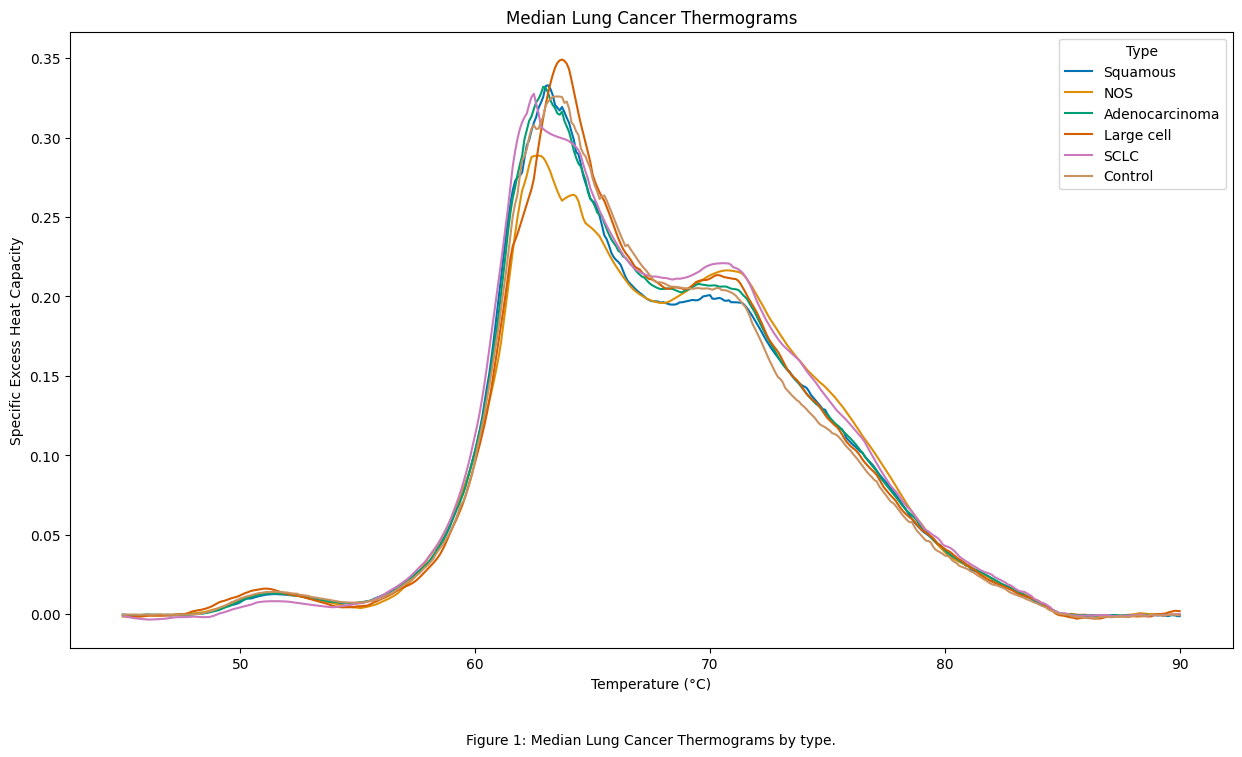

In [11]:
plt.figure(figsize=(15, 8))  # Adjust the figure size as needed
sns.lineplot(data=df_median, x='temperature', y='median', hue='type', palette='colorblind')
plt.xlabel('Temperature (\u00b0C)')
plt.ylabel('Specific Excess Heat Capacity')
plt.title('Median Lung Cancer Thermograms')
plt.legend(title='Type')
plt.text(0.5, -0.15, 'Figure 1: Median Lung Cancer Thermograms by type.', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

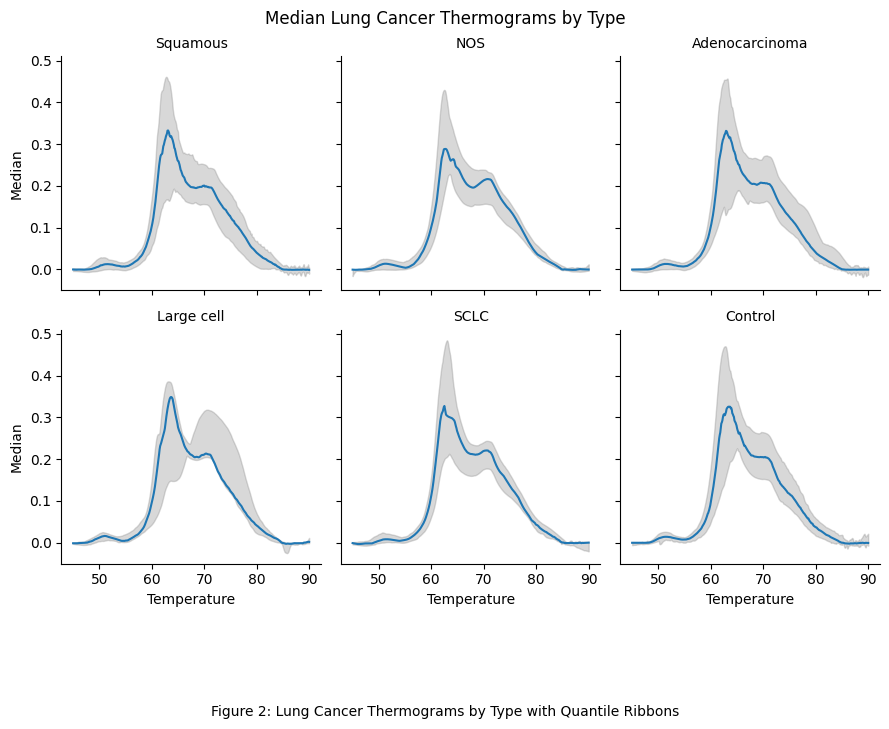

In [12]:
# Assuming df_median is your DataFrame
median_df = df_median

# courtesy of chatGPT
g = sns.FacetGrid(median_df, col="type", col_wrap=3, palette='colorblind')

g.set_axis_labels("Temperature", "Median")
g.set_titles(col_template="{col_name}")

# Define a custom function to add the ribbon to each panel
def add_ribbon(**kwargs):
    ax = plt.gca()
    panel_data = kwargs.pop("data")  # Get the data specific to the current panel
    
    sns.lineplot(data=panel_data, x='temperature', y='median', ax=ax, palette='colorblind')
    ax.fill_between(panel_data['temperature'], panel_data['lower_q'], panel_data['upper_q'], alpha=0.3, color='gray')

# Use FacetGrid.map_dataframe to apply the custom function to each panel
g.map_dataframe(add_ribbon)

# Add figure number and caption
plt.text(0.5, -0.15, 'Figure 2: Lung Cancer Thermograms by Type with Quantile Ribbons', ha='center', va='center', transform=g.fig.transFigure)
g.fig.suptitle("Median Lung Cancer Thermograms by Type", y=1.02)
# Show the plot
plt.show()


In [13]:
# set up for visuals
df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])

# get location of cut off values
lower_column_index = df.columns.get_loc("T51")
upper_column_index = df.columns.get_loc("T83.1")
label_column_index = df.columns.get_loc("CancerType")

column_indices = np.arange(lower_column_index, upper_column_index)
column_indices = np.append(column_indices, 0)
column_indices = np.append(column_indices, 1)



column_indices = np.append(column_indices, label_column_index)

df = df.iloc[:, column_indices]

df_long = pd.melt(df, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )

median_df = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')

median_df['temperature'] = median_df['temperature'].str.replace('T', '').astype(float)
results_table = pd.DataFrame(columns=["Pair", "Weighted Accuracy", "AUC"])

#median_df.to_excel("median_df.xlsx")

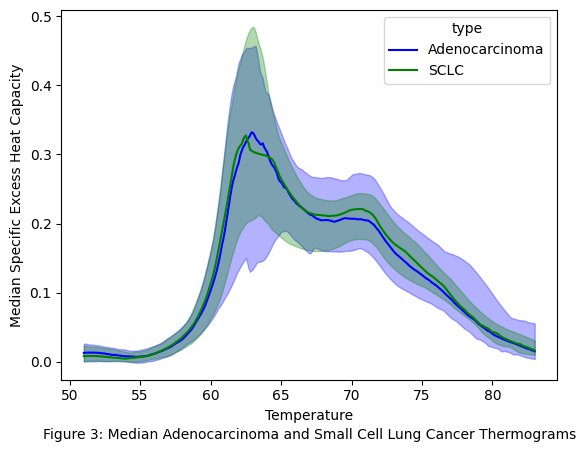

In [14]:
# adeno, sclc

graph_df = median_df[(median_df["type"] == "Adenocarcinoma") | (median_df["type"] == "SCLC")]
colors = {'Adenocarcinoma': 'blue', 'SCLC': 'green'}  # Specify colors for each type

# Create a line plot using Seaborn with matching colors
sns.lineplot(data=graph_df, x='temperature', y='median', hue='type', palette=colors)

# Create separate ribbons for each "type" with matching colors
for type_name in graph_df['type'].unique():
    type_data = graph_df[graph_df['type'] == type_name]
    plt.fill_between(type_data["temperature"], type_data["lower_q"], type_data["upper_q"], color=colors[type_name], alpha=0.3, label=type_name)

plt.xlabel("Temperature")
plt.ylabel("Median Specific Excess Heat Capacity")
plt.text(0.5, -0.15, 'Figure 3: Median Adenocarcinoma and Small Cell Lung Cancer Thermograms', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

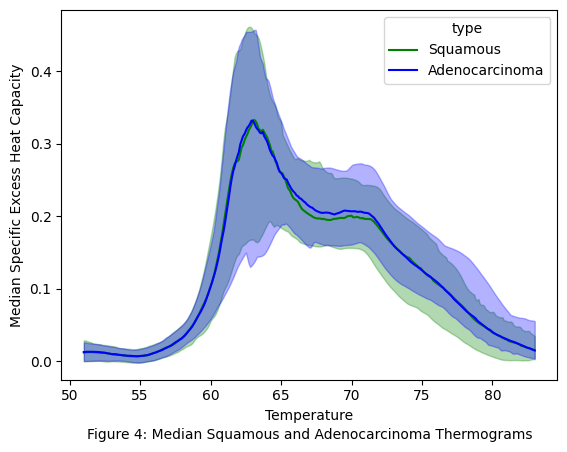

In [15]:
# adeno, squamous

graph_df = median_df[(median_df["type"] == "Adenocarcinoma") | (median_df["type"] == "Squamous")]
colors = {'Adenocarcinoma': 'blue', 'Squamous': 'green'}  # Specify colors for each type

# Create a line plot using Seaborn with matching colors
sns.lineplot(data=graph_df, x='temperature', y='median', hue='type', palette=colors)

# Create separate ribbons for each "type" with matching colors
for type_name in graph_df['type'].unique():
    type_data = graph_df[graph_df['type'] == type_name]
    plt.fill_between(type_data["temperature"], type_data["lower_q"], type_data["upper_q"], color=colors[type_name], alpha=0.3, label=type_name)

plt.xlabel("Temperature")
plt.ylabel("Median Specific Excess Heat Capacity")
plt.text(0.5, -0.15, 'Figure 4: Median Squamous and Adenocarcinoma Thermograms', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()


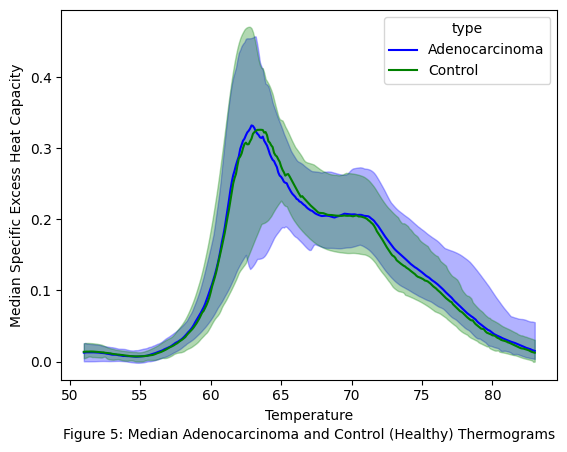

In [16]:
#adeno, control
graph_df = median_df[(median_df["type"] == "Adenocarcinoma") | (median_df["type"] == "Control")]
colors = {'Adenocarcinoma': 'blue', 'Control': 'green'}  # Specify colors for each type

# Create a line plot using Seaborn with matching colors
sns.lineplot(data=graph_df, x='temperature', y='median', hue='type', palette=colors)

# Create separate ribbons for each "type" with matching colors
for type_name in graph_df['type'].unique():
    type_data = graph_df[graph_df['type'] == type_name]
    plt.fill_between(type_data["temperature"], type_data["lower_q"], type_data["upper_q"], color=colors[type_name], alpha=0.3, label=type_name)

plt.xlabel("Temperature")
plt.ylabel("Median Specific Excess Heat Capacity")
plt.text(0.5, -0.15, 'Figure 5: Median Adenocarcinoma and Control (Healthy) Thermograms', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

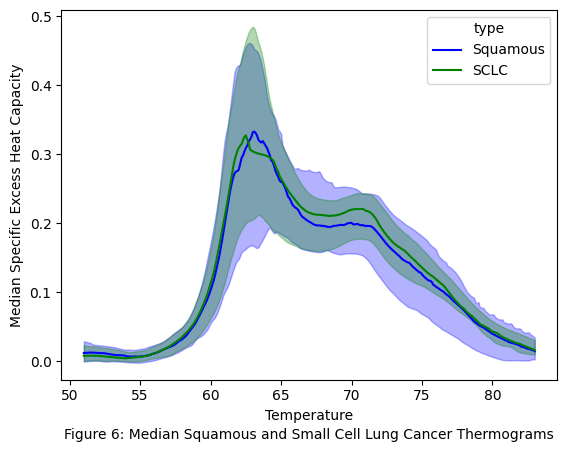

In [17]:
# sclc, squamous

graph_df = median_df[(median_df["type"] == "Squamous") | (median_df["type"] == "SCLC")]
colors = {'Squamous': 'blue', 'SCLC': 'green'}  # Specify colors for each type

# Create a line plot using Seaborn with matching colors
sns.lineplot(data=graph_df, x='temperature', y='median', hue='type', palette=colors)

# Create separate ribbons for each "type" with matching colors
for type_name in graph_df['type'].unique():
    type_data = graph_df[graph_df['type'] == type_name]
    plt.fill_between(type_data["temperature"], type_data["lower_q"], type_data["upper_q"], color=colors[type_name], alpha=0.3, label=type_name)

plt.xlabel("Temperature")
plt.ylabel("Median Specific Excess Heat Capacity")
plt.text(0.5, -0.15, 'Figure 6: Median Squamous and Small Cell Lung Cancer Thermograms', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

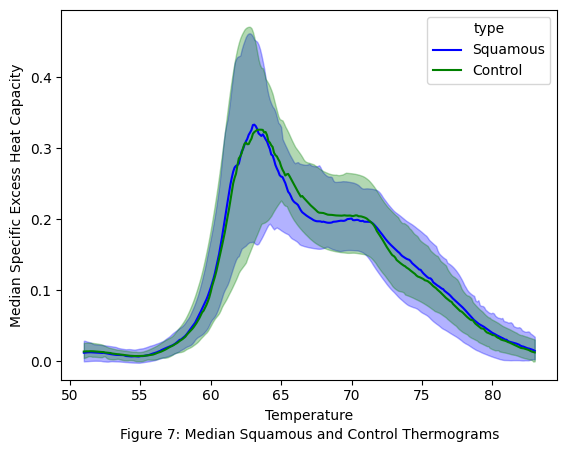

In [18]:
# squamous, control

graph_df = median_df[(median_df["type"] == "Squamous") | (median_df["type"] == "Control")]
colors = {'Squamous': 'blue', 'Control': 'green'}  # Specify colors for each type

# Create a line plot using Seaborn with matching colors
sns.lineplot(data=graph_df, x='temperature', y='median', hue='type', palette=colors)

# Create separate ribbons for each "type" with matching colors
for type_name in graph_df['type'].unique():
    type_data = graph_df[graph_df['type'] == type_name]
    plt.fill_between(type_data["temperature"], type_data["lower_q"], type_data["upper_q"], color=colors[type_name], alpha=0.3, label=type_name)

plt.xlabel("Temperature")
plt.ylabel("Median Specific Excess Heat Capacity")
plt.text(0.5, -0.15, 'Figure 7: Median Squamous and Control Thermograms', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

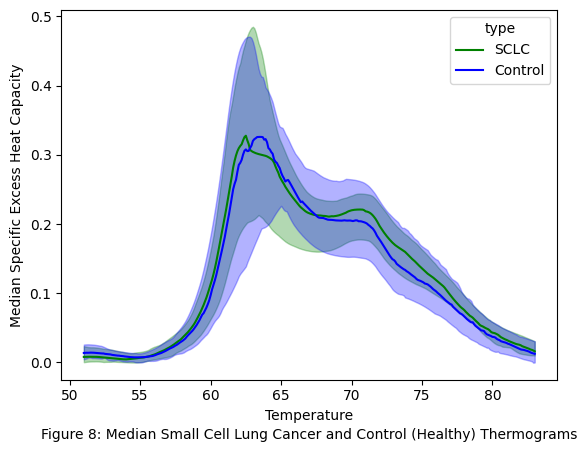

In [19]:
# control, sclc

graph_df = median_df[(median_df["type"] == "Control") | (median_df["type"] == "SCLC")]
colors = {'Control': 'blue', 'SCLC': 'green'}  # Specify colors for each type

# Create a line plot using Seaborn with matching colors
sns.lineplot(data=graph_df, x='temperature', y='median', hue='type', palette=colors)

# Create separate ribbons for each "type" with matching colors
for type_name in graph_df['type'].unique():
    type_data = graph_df[graph_df['type'] == type_name]
    plt.fill_between(type_data["temperature"], type_data["lower_q"], type_data["upper_q"], color=colors[type_name], alpha=0.3, label=type_name)

plt.xlabel("Temperature")
plt.ylabel("Median Specific Excess Heat Capacity")
plt.text(0.5, -0.15, 'Figure 8: Median Small Cell Lung Cancer and Control (Healthy) Thermograms', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

## Results of Stage Prediction
Thermograms were also used to predict lung cancer stage. Early vs late stages were predicted for each cancer type with 10 or more samples. Table 3 shows the groups and counts for each stage.


In [21]:
prev = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")
update = pd.read_excel('/Users/avery/OneDrive/Documents/publication_meta_data.xlsx')
merged = pd.merge(prev, update, left_on='pub_id', right_on="Patient")
df = merged.drop(["CancerType", "sample_id", "pub_id", "Patient"], axis = 1)
pd.DataFrame(df.groupby("Diagnosis")["Stage"].value_counts())

count
Diagnosis Stage       
AC        Early     36
          Late      34
Large     Early      4
          Late       2
Mix       Early      1
          Late       1
NOS       Late       6
          Early      2
SCC       Early     23
          Late      23
SCLC      Early     11
          Late       5

In [ ]:
df_long = pd.melt(prediction_df, id_vars=['Cancer and Stage'], var_name='temp', value_name='dsp' )

median = thermogram_utilities.median_curve(df_long, 'Cancer and Stage', 'temp', 'dsp')

median['temperature'] = median['temperature'].str.replace('T', '').astype(float)

In [1]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=median, x='temperature', y='median', hue='type', palette='colorblind')
plt.xlabel('Temperature (C)')
plt.ylabel('Specific Excess Heat Capacity')
plt.title('Median Lung Cancer Thermograms by Stage')
plt.show()

NameError: name 'plt' is not defined